# 人脸识别

*吴凡璐  中央财经大学 2018210803*

> **背景**  
本次数据集来自CVLab采集的114个人不同角度拍摄的797张图片，要求使用算法建模进行人脸识别：对图片进行训练集和测试集的划分，使用恰当的分类算法。

## 1. 图像预处理

首先，导入需要的库

In [12]:
import os 
from  PIL import Image
import random
import numpy as np
import pandas as pd

### 1). 先取一张图片进行探索

In [3]:
# 列出所有子文件夹的名字
dirl=os.listdir('C:\\Users\\wufan\\pythonfile\\database')
# 列出文件中图片的名字
dii=os.listdir('C:\\Users\\wufan\\pythonfile\\database\\'+str(1))
dii.pop(0) # 删除第一个网页的名字
dii

['MVC-001F.JPG',
 'MVC-002F.JPG',
 'MVC-003F.JPG',
 'MVC-004F.JPG',
 'MVC-005F.JPG',
 'MVC-006F.JPG',
 'MVC-007F.JPG']

尝试将原始图片灰度化，查看图片,人脸的基本特征没有损失

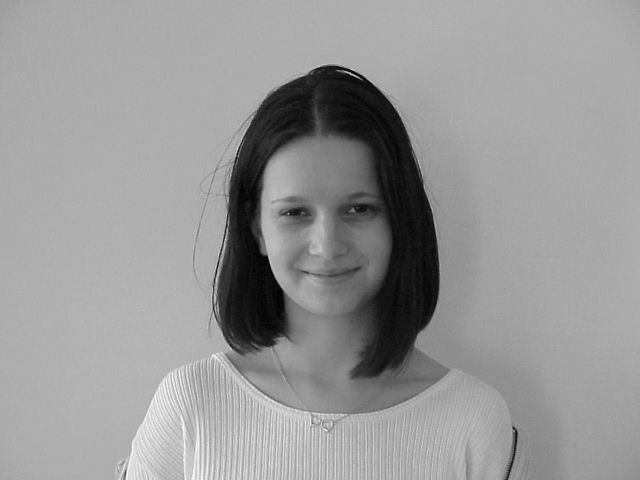

In [51]:
img = Image.open('C:\\Users\\wufan\\pythonfile\\database\\'+ str(1)+'\\'+dii[2]).convert("L")  #convert灰度化
img  # 查看图片

由于原图中人脸只占少部分，裁减掉背景和衣服部分的区域。发现裁剪区域为[90:350,180:460]最好地抠出了人脸。

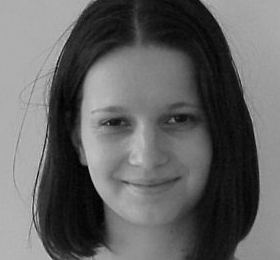

In [52]:
img1 = np.array(img)[90:350,180:460,]
im = Image.fromarray(np.uint8(img1))  #将改造后的向量重新转换成图片查看是否裁剪合适
im

In [14]:
img2 = img1.flatten() # 载入灰度图片并使之向量化
img2.shape   # 查看拉直的向量的维度

(72800,)

### 2). 载入数据集

**思路**  
- 如上探索，将所有数据集中的图片进行灰度化和一定比例的裁剪
- 数据集中共有114个文件夹，每个文件夹里是一个人的图片，图片数量从5到9不等。在载入图片的时候，首先对每个文件夹的图片顺序进行打乱，再抽取前90%的图片组成训练集，取1张图片放入测试集。  
  最后训练集是683张来自114个人的头像图片，测试集是由每个人1张随机角度的头像图片组成，共114张。

In [15]:
######将图片转换成数据集###########
def read_image_to_data(dirl):
    xytr = np.array([np.zeros(72801)],dtype=np.uint8)  # 初始化
    xyte = np.array([np.zeros(72801)],dtype=np.uint8)
    
    for i in range(len(dirl)):   # 开始遍历114个类
        di=os.listdir('C:\\Users\\wufan\\pythonfile\\database\\'+str(i+1))
        di.pop(0)              # 删除第一个网页的名字
        shuf=list(range(len(di)))   
        random.shuffle(shuf)   # 对每一个类别生成打乱的index
        Xi = np.array([np.zeros(72801)],dtype=np.uint8) # 初始化每一个类的类图片矩阵的第一行为维度为图片向量维度的0向量
        for j in range(len(di)):
            image = np.array(Image.open('C:\\Users\\wufan\\pythonfile\\database\\'+
                                         str(i+1)+'\\'+di[j]).convert("L"))[90:350,180:460,].flatten() # 载入灰度图片并使之向量化
            image = np.array([image])
            label = np.array([[i+1]],dtype=np.uint8)    # 标记为第(i+1)类
            x = np.array([np.append(image,label)])   # 将特征向量和标签合并为一行
            Xi = np.vstack((Xi,x))    # 将类别中所有图片的向量依次堆积成矩阵
        
        Xi = np.delete(Xi,0,0)  # 去除第一行零向量
        Xi = Xi[shuf]    # 打乱Xi的顺序以使训练集和测试集中的图片都有不同角度  
        Xtri = Xi[0:int(0.9*len(di))]   # 第i+1个类别分为训练集的部分,取90%的图片作为训练集
        Xtei = Xi[[-1],:]  # 第i+1个类别分为训练集的部分，取10%的图片
        xytr = np.vstack((xytr,Xtri)) # 将不同类别的训练集组合成大的训练集
        xyte = np.vstack((xyte,Xtei))  # 将不同类别的测试集组合成大的测试集
    
    xytr = np.delete(xytr,0,0)  # 删除第一行零向量
    xyte = np.delete(xyte,0,0)

    return xytr,xyte
        
traindata = read_image_to_data(dirl)[0]  # 所得训练集  683*72801
testdata = read_image_to_data(dirl)[1]   # 所得测试集  114*72801

xtrain = np.delete(traindata,[72800],axis=1) # 训练集变量  683*72800
xtest = np.delete(testdata,[72800],axis=1)    # 测试集变量   114*72800
ytrain = traindata[:,72800]                   # 训练集标签   683*1
ytest = testdata[:,72800]                     # 测试集标签   114*1

## 2. 图像数据降维

由于数据集维度较高，高达72801维，需要进行维度约简，在此使用PCA进行降维

In [19]:
import time
from sklearn.decomposition import PCA 
t0 = time.time()
n_components=60
pca=PCA(n_components=n_components)  # 确定降到60维
print("从 %d 张脸中提取出了 %d 个特征 "% (xtrain.shape[0],n_components))
pca.fit(xtrain)   # 训练模型
xtrain_pca=pca.fit_transform(xtrain)  # 产生降维后的训练集
xtest_pca=pca.transform(xtest)   # 产生降维后的测试集
t1 = time.time()
print("降维使用的时间为%0.3fs" % (t1 - t0))

从 683 张脸中提取出了 60 个特征 
降维使用的时间为8.490s


In [29]:
var_sum=np.sum(pca.explained_variance_ratio_)*100  # 查看总方差贡献率，提取出了多少信息
print ("提取出了原数据%.2f%%的信息"%var_sum)

提取出了原数据86.97%的信息


## 3. SVM多分类

本案例采用一对一多分类SVM对测试集进行预测

### 1). 训练模型

In [53]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
t3 = time.time()
svc = LinearSVC(random_state=0) # 线性SVM
svc = OneVsOneClassifier(svc)   # 一对一构建多分类器
svc.fit(xtrain_pca,ytrain)    # 训练模型
t4 = time.time()
print("训练SVM使用的时间为%0.3fs" % (t4 - t3))

训练SVM使用的时间为4.169s


### 2). 预测

In [54]:
#  预测
pre = svc.predict(xtest_pca)
acc = float((pre==ytest).sum())/len(ytest)
print ("模型预测的准确率为%0.2fs%%"%(acc*100))

模型预测的准确率为86.84s%


查看分错的样本

In [57]:
compare = pd.DataFrame({'correct_label':ytest,'predict_label':pre})
compare = compare[compare['correct_label']!=compare['predict_label']]# 查看分错的样本
compare.reset_index(drop=True)   # 列出被分错的15个样本

,correct_label,predict_label
0,3,19
1,21,79
2,32,87
3,39,41
4,49,58
5,50,56
6,55,13
7,59,31
8,75,105
9,79,52


试着查看分错的图片，以第21个人和第79个人为例（SVM误认为第21个人和第79个人长得一样）

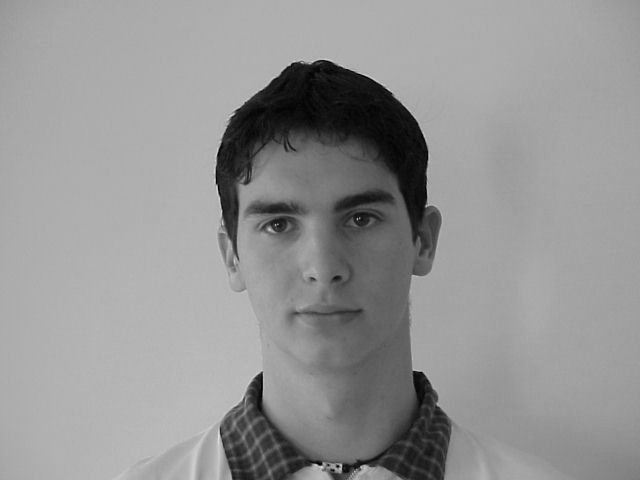

In [49]:
im21 = Image.open('C:\\Users\\wufan\\pythonfile\\database\\'+ str(21)+'\\'+dii[2]).convert("L")  #convert灰度化
im21

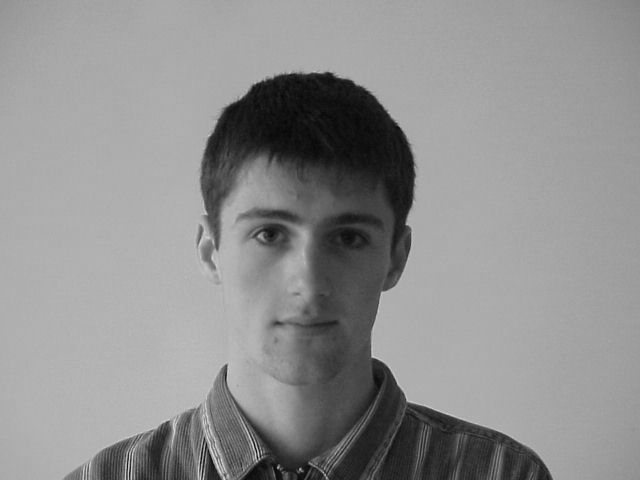

In [50]:
im79 = Image.open('C:\\Users\\wufan\\pythonfile\\database\\'+ str(79)+'\\'+dii[2]).convert("L")  #convert灰度化
im79